In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=UserWarning)
warnings.filterwarnings('ignore',category=ImportWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import pandas as pd
import numpy as np
import category_encoders as ce
from scipy.stats import randint
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from BorutaShap import BorutaShap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils.fixes import loguniform
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

import joblib
import operator

## Import data from nfl-data-py
##### https://pypi.org/project/nfl-data-py/

In [2]:
# Import csv file from nfl-data-py
df = pd.read_csv(r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/nfl_post_processing_run_pass_classification_data.csv')

df.shape

(41537, 127)

In [3]:
# Print columns with missing values
print(df.columns[df.isnull().any()].tolist())

[]


In [4]:
# Convert binary columns to integers
binary_columns = df.columns[df.isin([0,1]).all()].tolist()
df[binary_columns] = df[binary_columns].apply(pd.to_numeric, downcast='integer', errors='coerce', axis=1)

df.sample(2)

,week,posteam,defteam,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,qtr,down,...,drive_effct_play_pcnt,remaining_downs,remaining_yards_per_down,drive_start,two_min_warning,ep_sec_ratio,remain_yds_div_def_box,remain_yds_prod_def_box,run_ratio_off_priors,run_ratio_def_priors
39282,5,TEN,WAS,75,26.0,926.0,2726.0,1,1.0,1,...,0.0,3,3.333333,transfer_poss,0,0.001005,0.476190,23.333333,0.628571,0.50
24856,6,MIA,MIN,63,652.0,652.0,2452.0,1,2.0,2,...,-1.0,2,5.500000,transfer_poss,0,0.001990,0.916667,33.000000,0.461905,0.45


In [5]:
# Target frequency
target_count = df.play_type.value_counts(normalize=True)
target_count

play_type
pass    0.578207
run     0.421793
Name: proportion, dtype: float64

In [6]:
df['play_type'] = np.where(df['play_type'] == 'pass', 1, 0)

## Train test split data
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [7]:
# split data into target and feature datasets
X, y = df.loc[:, df.columns != 'play_type'], df['play_type']

initial_features = X.columns.to_list()

# Create train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=67)

print(X_train.shape[1], 'features before feature selection')
print('Column names:', X_train.columns.to_list())

126 features before feature selection
Column names: ['week', 'posteam', 'defteam', 'yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining', 'game_half', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'shotgun', 'no_huddle', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'score_differential', 'no_score_prob', 'fg_prob', 'safety_prob', 'td_prob', 'ep', 'wp', 'drive_play_count', 'spread_line', 'total_line', 'div_game', 'surface', 'play', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'n_offense', 'n_defense', 'qb_rank', 'qb_pts', 'qb_plays', 'qb_qbr_raw', 'qb_qbr', 'qb_pass', 'qb_run', 'play_sequence_game', 'play_sequence_series', 'run_formation', 'dtg_99to95', 'dtg_94to90', 'dtg_40to31', 'dtg_30to21', 'dtg_20to11', 'dtg_10to06', 'dtg_05to01', 'prev1_big_play_pass', 'prev2_big_play_pass', 'prev3_big_play_pass', 'drive_big_play_pass_pcnt', 'prev1_big_play_run', 'prev2_big_pla

## Baseline model
##### https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [8]:
# Create and fit baseline model to compare performance
baseline_model = DummyClassifier(strategy='most_frequent', random_state=67)
baseline_model.fit(X_train, y_train)

# Calculate model accuracy on test data
y_baseline_pred = baseline_model.predict(X_test)
# accuracy_score(y_test, y_baseline_pred)
print(f"Baseline accuracy: {(round(accuracy_score(y_test,y_baseline_pred),3)*100)}%")
print(f"Baseline f1 score: {(round(f1_score(y_test,y_baseline_pred),3)*100)}%")

Baseline accuracy: 58.199999999999996%
Baseline f1 score: 73.6%


## Encode categorical features
##### https://contrib.scikit-learn.org/category_encoders/leaveoneout.html

In [9]:
# Create list of features for each dtype
categorical_feat = list(X_train.select_dtypes(include='object'))

# Encoded column represents mean response over all rows for this category, providing one-column representation while avoiding direct response leakage
encoder = ce.LeaveOneOutEncoder(return_df=True, cols=categorical_feat)

X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)

print(X_train.shape[1], 'features after categorical encoding')

126 features after categorical encoding


## BorutaShap Feature selection
##### https://pypi.org/project/BorutaShap/

In [10]:
feature_model = RandomForestClassifier(ccp_alpha=1e-04,
                                       criterion='gini',
                                       max_depth=50,
                                       max_features=0.60,
                                       max_leaf_nodes=50,
                                       max_samples=0.40,
                                       min_impurity_decrease=1e-05,
                                       #min_samples_leaf=0.03,
                                       #min_samples_split=0.03,
                                       #min_weight_fraction_leaf=0.03,
                                       n_estimators=250,
                                       class_weight='balanced_subsample',
                                       bootstrap=True,
                                       oob_score=True,
                                       warm_start=False,
                                       n_jobs=6,
                                       random_state=67,
                                       )

In [11]:
# no model selected default is Random Forest
Feature_Selector = BorutaShap(importance_measure='shap',
                              classification=True,
                              model=feature_model,
                              )

Feature_Selector.fit(X=X_train,
                     y=y_train,
                     n_trials=250,
                     sample=False,
                     random_state=67,
                     )

100%|██████████| 250/250 [1:11:20<00:00, 17.12s/it]

14 attributes confirmed important: ['surface', 'shotgun', 'remaining_yards_per_down', 'wp', 'offense_formation', 'defense_personnel', 'offense_personnel', 'td_prob', 'remain_yds_div_def_box', 'defenders_in_box', 'game_seconds_remaining', 'drive_start', 'prev2_yards_gained', 'play']
112 attributes confirmed unimportant: ['prev1_no_huddle', 'prev2_shotgun', 'drive_no_huddle_pcnt', 'posteam', 'dtg_10to06', 'prev2_big_play_pass', 'prev1_qb_hit', 'prev1_negative_pass', 'play_sequence_series', 'qtr', 'drive_shotgun_pcnt', 'prev2_big_play_run', 'drive_big_play_pass_pcnt', 'drive_big_play_run_pcnt', 'prev3_first_down_run', 'defteam_timeouts_remaining', 'ep', 'qb_qbr_raw', 'prev1_first_down_pass', 'prev3_negative_run', 'safety_prob', 'prev1_negative_run', 'ydstogo', 'prev3_yards_gained', 'prev2_wpa', 'play_sequence_game', 'two_min_warning', 'prev2_qb_hit', 'no_score_prob', 'score_differential', 'qb_rank', 'yardline_100', 'dtg_40to31', 'fg_prob', 'prev1_play_pass_deep', 'prev2_no_huddle', 'drive

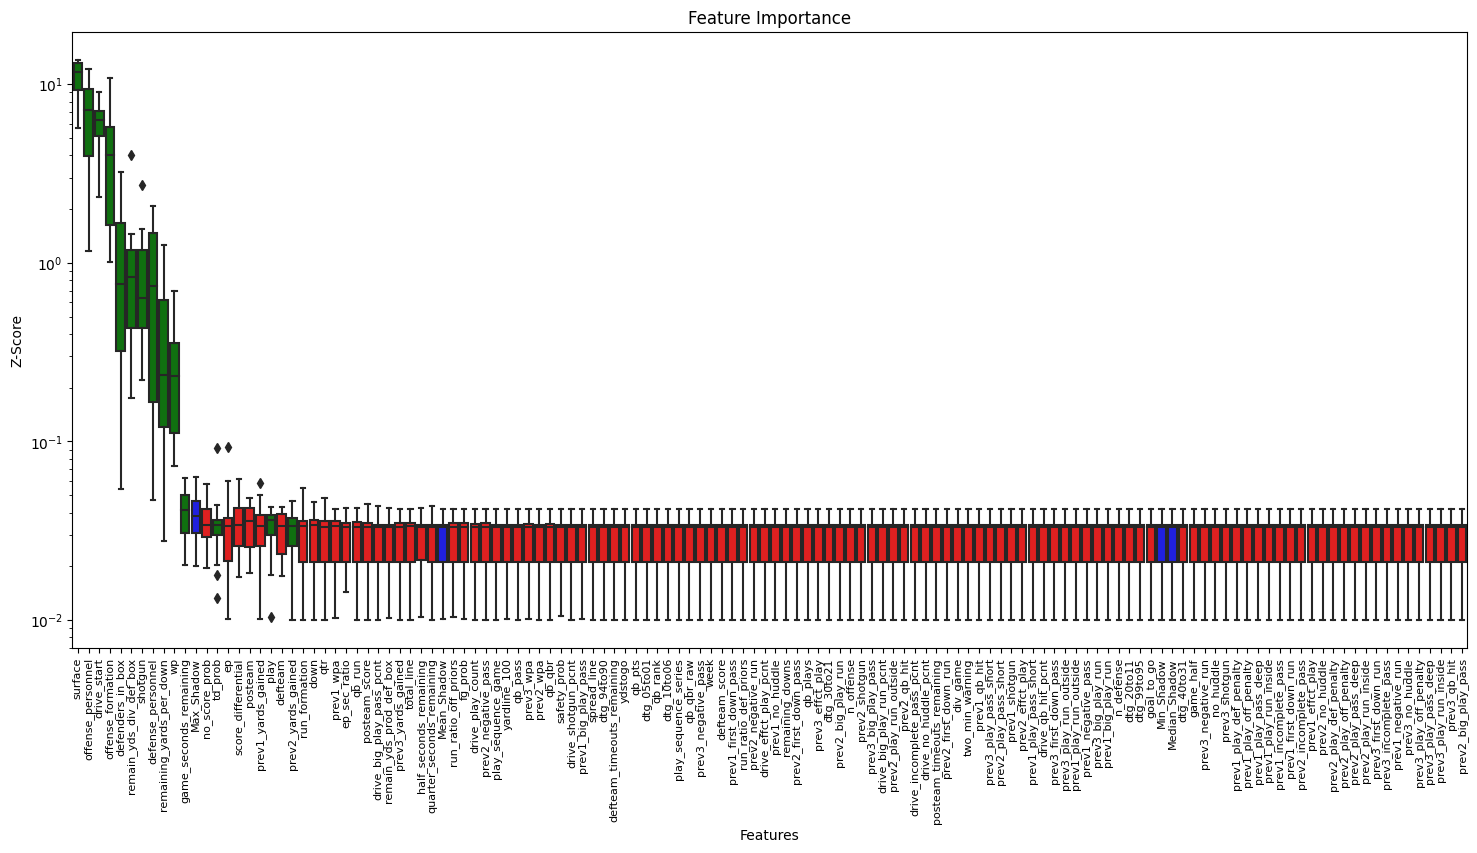

In [12]:
Feature_Selector.plot(which_features='all', figsize=(18, 8))

In [13]:
# Drops features that were identified by BorutaShap as not important
features_to_remove = Feature_Selector.features_to_remove

X_train = X_train.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)

# Print the shape of the new datasets
print('Training features:', X_train.shape[1])
print('Testing features:', X_test.shape[1])
print('Most important features:', X_train.columns.to_list())

Training features: 14
Testing features: 14
Most important features: ['game_seconds_remaining', 'shotgun', 'td_prob', 'wp', 'surface', 'play', 'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'prev2_yards_gained', 'remaining_yards_per_down', 'drive_start', 'remain_yds_div_def_box']


## Model pipeline
##### https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
##### https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
##### https://imbalanced-learn.org/stable/references/over_sampling.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
##### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
##### https://xgboost.readthedocs.io/en/stable/parameter.html

In [14]:
# Create feature type lists for column transform stage of the pipeline
ordinal_features = X_train.columns[X_train.isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]).all()].tolist()
categorical_features = list(X_train.select_dtypes(include='object'))
boolean_features = X_train.columns[X_train.isin([0, 1]).all()].tolist()

numeric_features = [x for x in X_train.columns if x not in ordinal_features]
numeric_features = [x for x in numeric_features if x not in categorical_features]
numeric_features = [x for x in numeric_features if x not in boolean_features]

print('categorical features:', len(categorical_features), ':', categorical_features)
print('ordinal features:', len(ordinal_features), ':', ordinal_features)
print('boolean features:', len(boolean_features), ':', boolean_features)
print('numeric features:', len(numeric_features), ':', numeric_features)

categorical features: 0 : []
ordinal features: 1 : ['defenders_in_box']
boolean features: 1 : ['shotgun']
numeric features: 12 : ['game_seconds_remaining', 'td_prob', 'wp', 'surface', 'play', 'offense_formation', 'offense_personnel', 'defense_personnel', 'prev2_yards_gained', 'remaining_yards_per_down', 'drive_start', 'remain_yds_div_def_box']


In [15]:
# Outlier removal
def iqr_outliers(x, features):

    out_index_list = []
        
    for col in features:
        q1 = np.nanpercentile(x[col], 25.)
        q3 = np.nanpercentile(x[col], 75.)
        
        cut_off = (q3 - q1) * 1.5
        upper, lower = q3 + cut_off, q1 - cut_off
                
        outliers_index = x[col][(x[col] < lower) | (x[col] > upper)].index.tolist()
        out_index_list.extend(outliers_index)
        
    # Remove duplicates
    list(set(out_index_list)).sort()

In [16]:
# Specify the transformations per data type
num_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                            ('iqr_outlier', iqr_outliers(X_train, numeric_features)),
                            ('power_trans', PowerTransformer(method='yeo-johnson', copy=False)),
                            ('scaler', StandardScaler()),
                           ])

cat_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('onehot_encoder', OneHotEncoder(sparse=False, handle_unknown='infrequent_if_exist')),
                           ])

ord_trans = Pipeline(steps=[('simple_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                            ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
                            ('scaler', StandardScaler()),
                           ])
                             
Column_Transform = ColumnTransformer(transformers=[('numeric_transform', num_trans, numeric_features),
                                                   ('categorical_transform', cat_trans, categorical_features),
                                                   ('ordinal_transform', ord_trans, ordinal_features),
                                                   ],
                                     remainder='passthrough',
                                    )

In [17]:
# Specify number of target classes
n_classes = y_train.nunique()

# Specify HalvingRandomSearchCV halving_parameter (aka factor)
halving_parameter = 3.0

# Specify the HalvingRandomSearchCV minimum/maximum resources
max_resource = 3000
resource_divisor = 3.0
min_resource = int(round((max_resource / resource_divisor), 0))

In [18]:
def random_search():
    
    pipeline1 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', RandomForestClassifier()),
    ])
    
    pipeline2 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', ExtraTreesClassifier()),
    ])
    
    pipeline3 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', GradientBoostingClassifier()),
    ])
    
    pipeline4 = Pipeline([
    ('col', Column_Transform),
    ('smpl', ADASYN(n_neighbors=n_classes, sampling_strategy='not majority', random_state=67)),
    ('clf', AdaBoostClassifier()),
    ])

    # RandomForestClassifier
    parameters1 = {
    'clf__bootstrap': [True],
    'clf__ccp_alpha':  loguniform(1e-6, 1e-00),
    'clf__criterion': ['gini'],
    'clf__max_depth': randint(2, 12),
    'clf__max_features': loguniform(0.01, 0.20),
    'clf__min_impurity_decrease': loguniform(1e-08, 1e-04),
    'clf__max_samples': loguniform(0.10, 0.90), # max_samples is not supported for bootstrap=False
    'clf__min_samples_leaf': loguniform(0.02, 0.20),
    'clf__min_samples_split': loguniform(0.02, 0.20),
    'clf__min_weight_fraction_leaf':  loguniform(0.02, 0.15),
    'clf__oob_score': [True],
    'clf__warm_start': [False],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }
    
    # ExtraTreesClassifier
    parameters2 = {
    'clf__bootstrap': [False],
    'clf__ccp_alpha': loguniform(1e-08, 1e-04),
    'clf__criterion': ['gini'], #,'log_loss'],
    'clf__max_depth': randint(10, 35),
    'clf__max_features': loguniform(0.50, 1.00),
    'clf__max_leaf_nodes': randint(15, 75),
    # 'clf__max_samples': loguniform(0.30, 0.99), # max_samples is not supported for bootstrap=False
    'clf__min_impurity_decrease': loguniform(1e-09, 1e-03),
    'clf__min_samples_leaf': loguniform(0.02, 0.50),
    'clf__min_samples_split': loguniform(0.02, 0.50),
    'clf__min_weight_fraction_leaf': loguniform(0.02, 0.50),
    'clf__oob_score': [False],
    'clf__warm_start': [True],
    'clf__n_jobs': [6],
    'clf__random_state': [67],
    }
            
    # GradientBoostingClassifier
    parameters3 = {
    'clf__ccp_alpha': loguniform(1e-06, 1e-01),
    'clf__learning_rate': loguniform(1e-08, 1e-03),
    'clf__loss': ['log_loss'],
    'clf__subsample': loguniform(0.10, 0.90),
    'clf__max_depth': randint(1, 12), 
    'clf__max_features': loguniform(0.01, 0.20), 
    'clf__max_leaf_nodes': randint(2, 20),
    'clf__min_impurity_decrease': loguniform(1e-08, 1e-04),
    'clf__min_samples_leaf': loguniform(0.02, 0.20),
    'clf__min_samples_split': loguniform(0.02, 0.20),
    'clf__n_iter_no_change': [50, 100],
    'clf__tol': loguniform(1e-09, 1e-04),
    'clf__validation_fraction': loguniform(0.05, 0.15),
    'clf__warm_start': [False], # True
    'clf__random_state': [67],
    }

    # AdaBoostClassifier
    parameters4  = {
    'clf__algorithm': ['SAMME','SAMME.R'],
    'clf__learning_rate': loguniform(0.001, 1.0),
    'clf__random_state': [67],
    }

    pars = [parameters1, parameters2, parameters3, parameters4]
    pips = [pipeline1, pipeline2, pipeline3, pipeline4]

    result = []
    
    for i in range(len(pars)):
        
        rs = HalvingRandomSearchCV(pips[i],
                                   pars[i],
                                   factor=halving_parameter,
                                   resource='clf__n_estimators',
                                   n_candidates='exhaust',
                                   min_resources=min_resource,
                                   max_resources=max_resource,
                                   scoring='f1_micro',
                                   aggressive_elimination=False,
                                   return_train_score=True,
                                   refit=True,
                                   cv=5,
                                   n_jobs=6,
                                   verbose=1,
                                   random_state=67,
                                   error_score='raise',
                                  )

        # Fit models on training data
        rs = rs.fit(X_train, y_train)
        
        # Apply models to test data to determine model performance
        y_pred = rs.predict(X_test)
        y_pred_prob = rs.predict_proba(X_test)[:, 1]

        print(" ")
        print(" ")
        
        # storing model results
        result.append({
        'grid': rs,
        'cv results': rs.cv_results_,
        'train f1 score': rs.best_score_,
        'best params': rs.best_params_, 
        'best estimator': rs.best_estimator_,
        'feature importance': rs.best_estimator_.named_steps['clf'].feature_importances_,
        'test f1 score': f1_score(y_test, y_pred, average='micro'),
        'test accuracy score': accuracy_score(y_test, y_pred),
        'test roc auc score': roc_auc_score(y_test, y_pred_prob),
        'test classification report': classification_report(y_test, y_pred, target_names=['pass','run'], digits=5),
        'test confusion matrix': confusion_matrix(y_test, y_pred),
        'cv': rs.cv,
        'model #': i + 1
        })

    # sorting results by best test score
    result = sorted(result, key=operator.itemgetter('test f1 score'), reverse=True)
    
    print(' ')
    for element in result:
        if element['model #']==1:
            print('Random Forest classifier: ')
        elif element['model #']==2:
            print('ExtraTrees classifier: ')
        elif element['model #']==3:
            print('GradientBoosting classifier: ')
        elif element['model #']==4:
            print('AdaBoost classifier: ')
        else:
            print('Other: ')  
        
        print('Parameters:  ' + str(element['best params']))
        print(' ')
        print('Train f1 score:      ' + str(element['train f1 score']))
        print('Test f1 score:       ' + str(element['test f1 score']))
        print('Test roc auc score:  ' + str(element['test roc auc score']))
        print(element['test classification report'])
        print(element['test confusion matrix'])
        print(' ')
        print('-----------------------')
        print(' ')

    # Save best model as pickle file
    joblib.dump(rs.best_params_, r'/Users/ttas2/Documents/Python/nfl-machine-learning-models/output_files/run_pass_classifier_results.pkl', compress=1)

In [19]:
%%capture --no-stdout --no-display
random_search()

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 3000
aggressive_elimination: False
factor: 3.0
----------
iter: 0
n_candidates: 3
n_resources: 1000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 3000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
 
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 3000
aggressive_elimination: False
factor: 3.0
----------
iter: 0
n_candidates: 3
n_resources: 1000
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 1
n_candidates: 1
n_resources: 3000
Fitting 5 folds for each of 1 candidates, totalling 5 fits
 
 
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 1000
max_resources_: 3000
aggressive_elimination: False
factor: 3.0
----------
iter: 0
n_candidates: 3
n_resources: 1000
Fitting 5 folds for each of 3 candidate